<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/08-ensembles/Ensembles_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

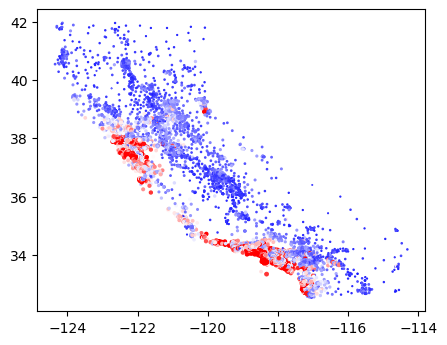

In [3]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [21]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [24]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

# KNN - model

In [67]:
# with optimization of hyper-parameters
grid_params = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
gs = GridSearchCV(KNeighborsRegressor(),
                 grid_params,
                 verbose=1,
                 cv=5,
                 n_jobs=-1)
gs_results = gs.fit(X_train[['Longitude', 'Latitude']], y_train)
predictions = gs_results.predict(X_test[['Longitude', 'Latitude']])
print("MSE score of KNN with optimized hyper-params: ", mean_squared_error(y_test, predictions))
print("The optimized hyper-parameters are:", gs.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
MSE score of KNN with optimized hyper-params:  0.2998085851664989
The optimized hyper-parameters are: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}


In [59]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train[['Longitude', 'Latitude']], y_train)
predictions = model_knn.predict(X_test[['Longitude', 'Latitude']])
print("MSE score of KNN: ", mean_squared_error(y_test, predictions))

MSE score of KNN:  0.3009814178451643


# Random forest

In [71]:
# learning with optimization of hyper-parameters
grid_params = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 1, 3, 5],
    'min_samples_leaf': [5, 50, 100]
}
gs = GridSearchCV(RandomForestRegressor(random_state=42),
                 grid_params,
                 verbose=1,
                 cv=5,
                 n_jobs=-1)
gs_results = gs.fit(X_train.drop((['Longitude', 'Latitude']), axis=1), y_train)
predictions = gs_results.predict(X_test.drop((['Longitude', 'Latitude']), axis=1))
print("MSE score of Random Forest with optimized hyper-params: ", mean_squared_error(y_test, predictions))
print("The optimized hyper-parameters are:", gs.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
MSE score of Random Forest with optimized hyper-params:  0.4244021481444316
The optimized hyper-parameters are: {'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}


In [66]:
model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
model_rf.fit(X_train.drop((['Longitude', 'Latitude']), axis=1), y_train)
predictions = model_rf.predict(X_test.drop((['Longitude', 'Latitude']), axis=1))
print("MSE score of Random Forest: ", mean_squared_error(y_test, predictions))

MSE score of Random Forest:  0.43403946845337965


# Ensemble

In [72]:
col_rf = make_column_transformer(('drop', ['Latitude', 'Longitude']), remainder='passthrough')
col_knn = make_column_transformer(('passthrough', ['Latitude', 'Longitude']), remainder='drop')
pipeline_rf = make_pipeline(col_rf, RandomForestRegressor(n_estimators=100, random_state=42, min_samples_leaf=5, max_depth=None))
pipeline_knn = make_pipeline(col_knn, KNeighborsRegressor(metric='euclidean', n_neighbors=8, weights='uniform'))
estimators = [('rf', pipeline_rf),
              ('knn', pipeline_knn)]
sclf = StackingRegressor(estimators=estimators,
                         final_estimator=LinearRegression())
sclf.fit(X_train, y_train)
predictions = sclf.predict(X_test)
print('The MSE score of ensembled method is:', mean_squared_error(y_test, predictions))

The MSE score of ensembled method is: 0.231420387436048


# Comment

So, the aforeconveyed experiments have shown the following results:
1) MSE-losses are lower if the model is trained on the optimal parameters. That's obvious - the better a model has been trained - the better results we get;

2) KNN tends to be more suitable model for the given task in comparison with Random Forest, since the MSE-loss shows lower results in the case of K-nearest neighbours algorithm;

3) Using Stacking Regressor allows to combine three models - KNN, Random Forest and Linear Regression. Taking the average, ensemble-approach gives the best result in the context of MSE-loss. 